## **NOTE**: Change runtime to GPU before you start!
In the header menu, go to `Runtime` -> `Change runtime type` -> Switch `Hardware accelarator` to `GPU`

In [2]:
!pip install livelossplot

!printf "\n\n##################\n\nOUR GPU CONFIGURATION IS:\n\n"
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##################

OUR GPU CONFIGURATION IS:

Mon Mar 13 10:21:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------

# Overview

In this lab we will 

1. Learn how to train neural network models to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as we go.
2. Use what we learn (and the code from step 1) to train our own models on the MNIST digits dataset

# 1) Introduction to classification with TensorFlow Keras



This first section is a follow-along guide to image classification using [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. TensorFlow is Google's framework for deep learning - Highly utilized in both research and industry.

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

from livelossplot import PlotLossesKeras

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)

2.11.0


In [ ]:
seed = 420
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Import the Fashion MNIST dataset

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [4]:
# Importing dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
FASHION_CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, 10,000 images in the testing set, with each image represented as 28 x 28 pixels:

In [6]:
print(
    f"Train IMGs shape: {train_images.shape}\n",
    f"Test IMGs shape: {test_images.shape}"
)

Train IMGs shape: (60000, 28, 28)
 Test IMGs shape: (10000, 28, 28)


Each label is an integer between 0 and 9:

In [7]:
print(f"Train labels: {train_labels} ] Length: {len(train_labels)}\n")
print("Value counts:")
pd.Series(train_labels).map(pd.Series(FASHION_CLASS_NAMES)).value_counts()

Train labels: [9 0 0 ... 3 0 5] ] Length: 60000

Value counts:


Ankle boot     6000
T-shirt/top    6000
Dress          6000
Pullover       6000
Sneaker        6000
Sandal         6000
Trouser        6000
Shirt          6000
Coat           6000
Bag            6000
dtype: int64

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

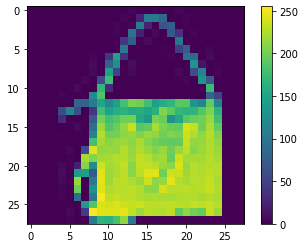

In [8]:
plt.figure()
plt.imshow(random.choice(train_images))
plt.colorbar()
plt.grid(False)

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [ ]:
# scaling of train and test set
train_images = train_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

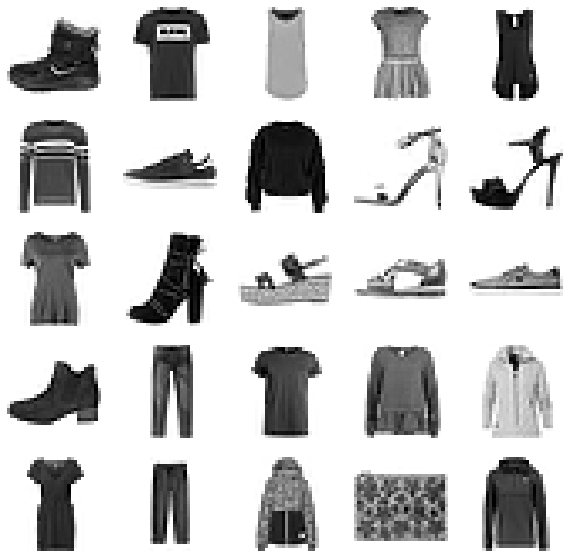

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(FASHION_CLASS_NAMES[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [10]:
# Create a sequential model object
model = tf.keras.Sequential([
    # Flatten the input data to a 1D array
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # Add a dense layer with 128 neurons and relu activation function
    tf.keras.layers.Dense(128, activation='relu'),
    # Add a dense layer with 10 neurons (one for each class)
    tf.keras.layers.Dense(10)
])

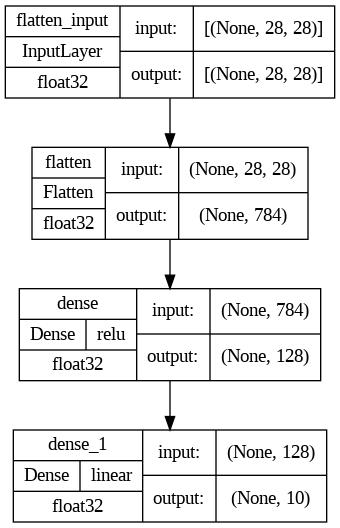

In [11]:
# plotting the model
plot_model(
    model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [12]:
# Compiles the model with the specified configuration
model.compile(
    optimizer='adam', # Use the Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Use SparseCategoricalCrossentropy loss function with logits
    metrics=['accuracy'] # Track accuracy as a metric during training and evaluation
)


## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

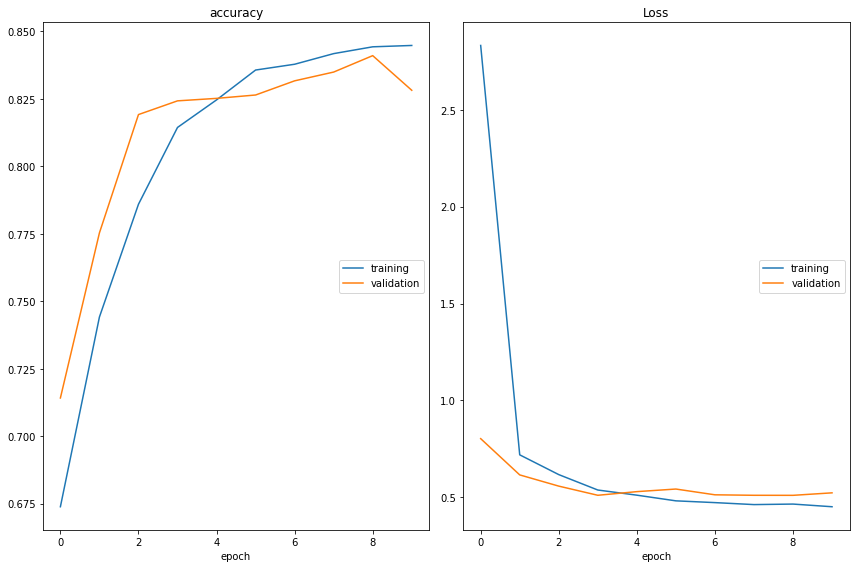

accuracy
	training         	 (min:    0.674, max:    0.845, cur:    0.845)
	validation       	 (min:    0.714, max:    0.841, cur:    0.828)
Loss
	training         	 (min:    0.451, max:    2.832, cur:    0.451)
	validation       	 (min:    0.510, max:    0.803, cur:    0.523)
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4513 - accuracy: 0.8448 - val_loss: 0.5230 - val_accuracy: 0.8282


In [13]:
# Fitting model to training data
model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

As the model trains, the loss and accuracy metrics are displayed. This model should reach an accuracy of about 0.84 (or 84%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [14]:
# Evaluating model performance on test set
train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

1875/1875 - 3s - loss: 0.4552 - accuracy: 0.8423 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.5309 - accuracy: 0.8202 - 648ms/epoch - 2ms/step

Train accuracy: 0.8422999978065491
Test accuracy: 0.8202000260353088


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [15]:
# Create a Sequential model in TensorFlow Keras API
probability_model = tf.keras.Sequential(
    [
        # Add the pre-trained model as the first layer of the new model
        model, 
        # Add a Softmax layer as the final layer of the new model
        tf.keras.layers.Softmax()
    ]
)

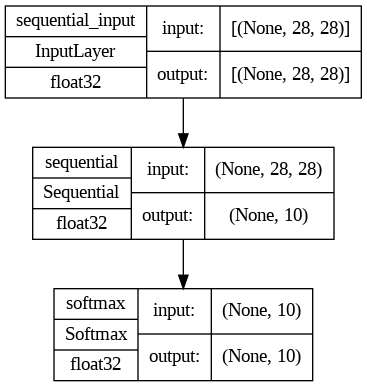

In [16]:
plot_model(
    probability_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

In [17]:
# Make predictions
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 1ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [18]:
predictions[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01801507, 0.        , 0.02706689, 0.        , 0.954918  ],
      dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [19]:
i = random.choice(range(predictions.shape[0]))
pred = np.argmax(predictions[i])
f"Higest probability for class: {pred} ({FASHION_CLASS_NAMES[pred]}) | Correct label: {test_labels[i]} ({FASHION_CLASS_NAMES[test_labels[i]]})"

'Higest probability for class: 2 (Pullover) | Correct label: 4 (Coat)'

So, the model is most confident that this image is an ankle boot, or `FASHION_CLASS_NAMES[9]`. Examining the test label shows that this classification is correct:

Graph this to look at the full set of 10 class predictions.

In [20]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f"{FASHION_CLASS_NAMES[predicted_label]} {100*np.max(predictions_array):2.0f}% ({FASHION_CLASS_NAMES[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(FASHION_CLASS_NAMES)), FASHION_CLASS_NAMES, size='small', rotation=30)
  plt.yticks(range(100))
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

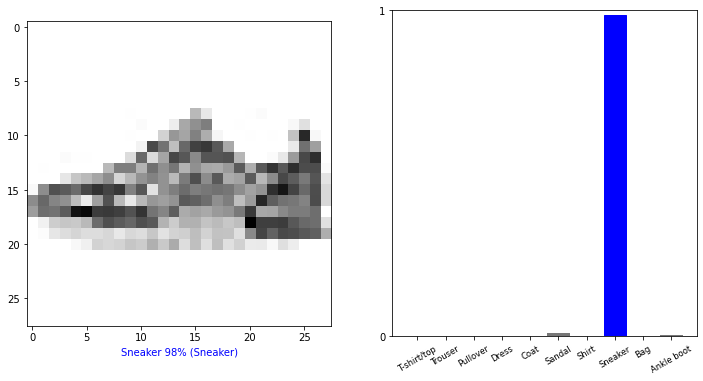

In [21]:
i = random.choice(range(predictions.shape[0]))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

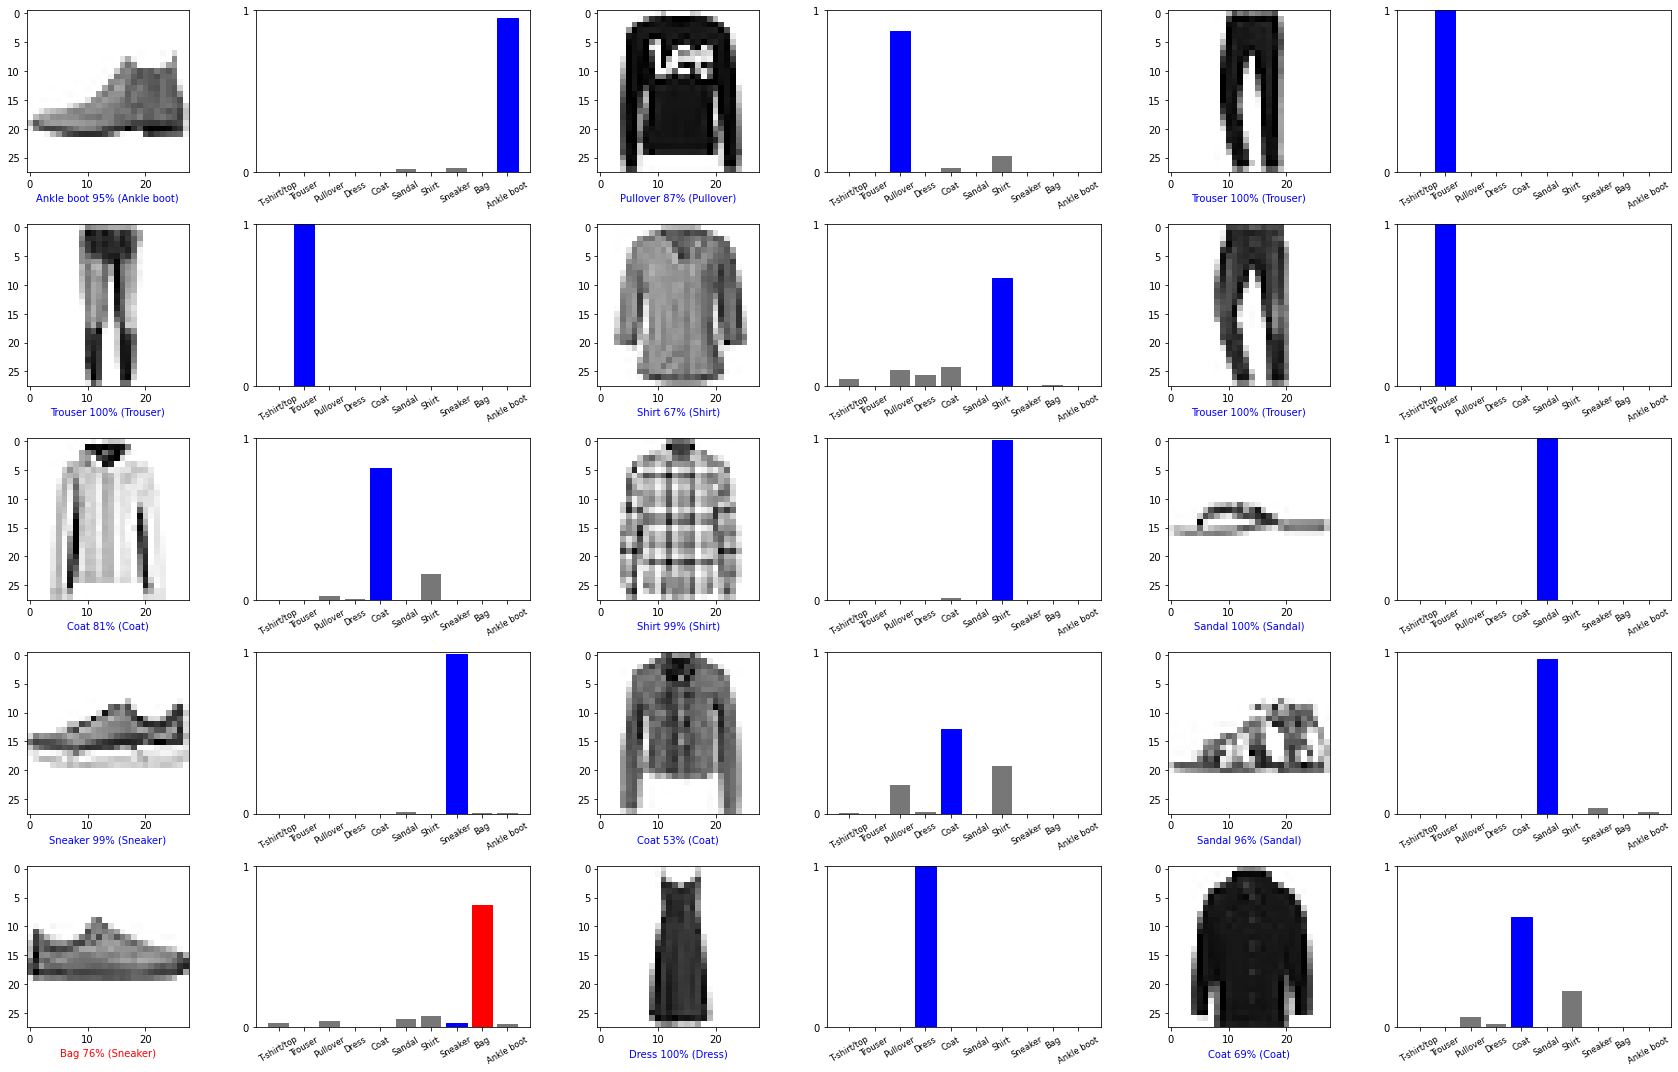

In [22]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*4*num_cols, 3*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [23]:
# Grab an image from the test dataset.
i = random.choice(range(test_images.shape[0]))
img = test_images[i]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [24]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [25]:
# Predicting lable for a single image
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 34ms/step
[[0.         0.         0.         0.         0.         0.0292185
  0.         0.96731246 0.00067676 0.00279228]]


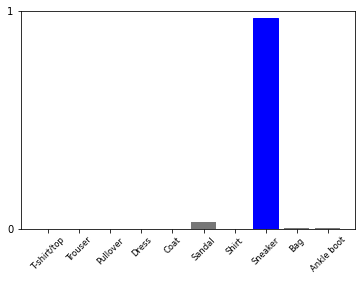

In [26]:

plot_value_array(
    i, 
    predictions_single[0], 
    test_labels
)
plt.xticks(range(10), FASHION_CLASS_NAMES, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [27]:
pred_cat = np.argmax(predictions_single[0])
pred_cat, FASHION_CLASS_NAMES[pred_cat]

(7, 'Sneaker')

---
---
---

# Question 1

With the guide above, we are well-equipped to try out the techniques on our own data. You are already familiar with the MNIST Digits dataset from lab 3. Follow the steps below.

- Instead of the MNIST fashion data, load the **original MNIST digit data**. (tf.keras.datasets.mnist)
- Train a the model (Use the same architecture as above)
- print accuracy and loss the training dat and for the testing data.

**HINTS:** You want to follow the exact steps above
- Load the data
- Scale the images
- Define your model
- Compile your model
- Fit your model
- Evaluate your model

## Import the Digit MNIST dataset

In [28]:
# load the MNIST dataset and store it in the variable mnist
mnist = tf.keras.datasets.mnist 

# unpack the training and testing data into separate variables
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



11490434/11490434 [==============================] - 1s 0us/step


## Scale the images

In [29]:
# normalize the pixel values of the training and testing images
train_images = train_images / 255.0
test_images = test_images / 255.0

## Build the model

### Set up the layers

In [30]:
# Define a Sequential model 
digits_model = tf.keras.Sequential([
    # Flatten the input images to a 1D array 
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # Add a Dense layer with 128 neurons and ReLU activation function
    tf.keras.layers.Dense(128, activation='relu'),
    # Add a Dense layer with 10 neurons (one for each digit) and no activation function specified
    tf.keras.layers.Dense(10)
])

### Compile the model

In [31]:
# Compiles the model with the specified configuration
digits_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

### Fit the model to training set

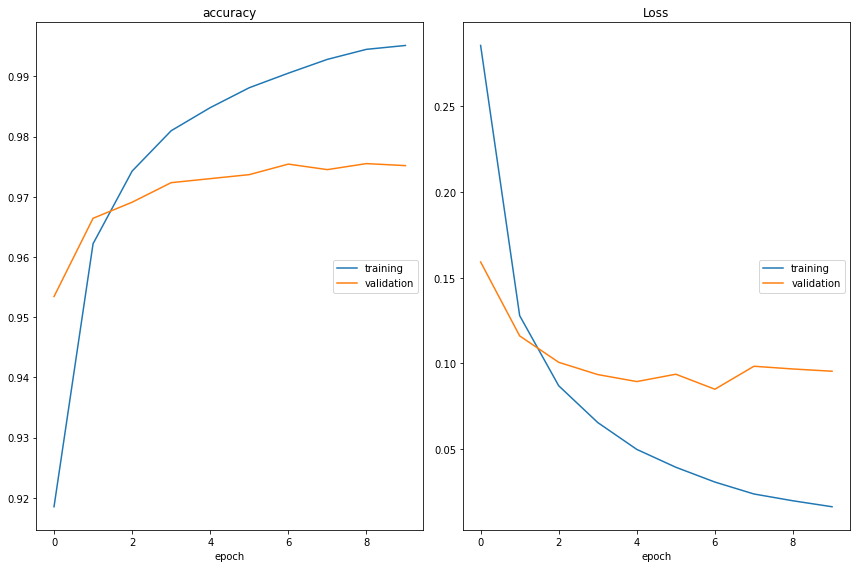

accuracy
	training         	 (min:    0.919, max:    0.995, cur:    0.995)
	validation       	 (min:    0.953, max:    0.975, cur:    0.975)
Loss
	training         	 (min:    0.016, max:    0.286, cur:    0.016)
	validation       	 (min:    0.085, max:    0.159, cur:    0.095)
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0955 - val_accuracy: 0.9752


In [32]:
# Fitting the model to training set
digits_model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

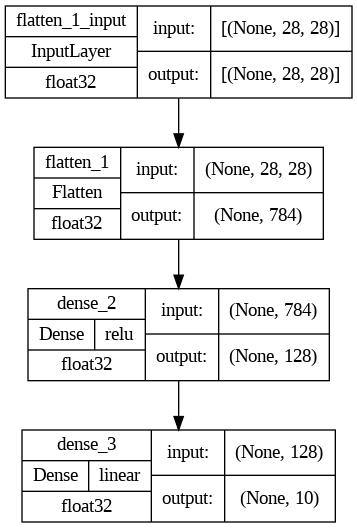

In [33]:
plot_model(
    digits_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

### Evaluate accuracy

In [34]:
# Evaluating model performance on test set
train_loss, train_acc = digits_model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_acc = digits_model.evaluate(test_images,  test_labels, verbose=2)


print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

1875/1875 - 3s - loss: 0.0290 - accuracy: 0.9923 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.0878 - accuracy: 0.9770 - 640ms/epoch - 2ms/step

Train accuracy: 0.9923333525657654
Test accuracy: 0.9769999980926514


<h2>Question 2 (Read-along)</h2>

Next, we want to load in an unseen image. Follow along in the 3 code cells below.
We will
- Load a a digit image using the code snippet below
- Display the image
- Print the type of the image
- Transform the image
- Display the transformed image


In [35]:
# Load digit image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://i.stack.imgur.com/fyPhv.jpg")
Img = Image.open(BytesIO(response.content))

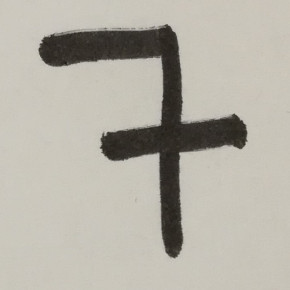

In [36]:
# Display the image
Img

<class 'PIL.JpegImagePlugin.JpegImageFile'>


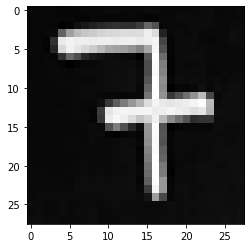

(1, 28, 28)


In [37]:
# Print the type of image
print(type(Img))

# transform
out = Img.resize((28,28))
imgArray = np.array(out)
gray = imgArray[:,:,0] / 255.0

plt.imshow(gray, cmap=plt.cm.binary)
plt.show()

# Add the image to a batch where it's the only member -> Convert an (28, 28) img to (1, 28, 28)
img = (np.expand_dims(gray,0))
# Print transformed image
print(img.shape)


# Question 3

We have our digits model, and we have our test image. Next, 

- Create a `digits_probability_model` by adding a `Softmax` layer to our digits_model. (See code cell 16 in the guide above!)
- Using this probability model, run `.predict`on our img, created above in Q2
- Now test the model to see whether it correctly classifies Img. What classification does it give? 

In [38]:
# Create a probability model for digits using Keras Sequential model
digits_probability_model = tf.keras.Sequential(
    [
        digits_model, # Include the previously trained digits_model as the first layer of the Sequential model
        tf.keras.layers.Softmax() # Add a Softmax activation function as the final layer to convert the model's output into a probability distribution
    ]
)

In [39]:
# Make a prediction using a trained machine learning model and an image
predictions_single = digits_probability_model.predict(img)

# Print the array of predictions
print(f"Array of predictions: {predictions_single}")

# Get the index of the highest probability prediction
print(np.argmax(predictions_single[0]))

1/1 [==============================] - 0s 51ms/step
Array of predictions: [[0.         0.         0.         0.         0.         0.99999523
  0.00000475 0.00000008 0.         0.        ]]
5


# Question 8

The digits model has a Dense layer with 128 nodes. 
- Change this to 256, and 
- print the accuracy in training and test.

**HINT:** You will want to copy paste from Q1

## Build the model

In [40]:
# Define a Sequential model to be used for recognizing digits in images
digits_model = tf.keras.Sequential([
    # Input layer: Flattens 28x28 image into 784x1 array
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    
    # Hidden layer: Dense layer with 256 nodes and ReLU activation function
    tf.keras.layers.Dense(256, activation='relu'),
    
    # Output layer: Dense layer with 10 nodes (one for each digit 0-9)
    tf.keras.layers.Dense(10)
])

# Compile the model using Adam optimizer, sparse categorical crossentropy loss function, and accuracy as metric
digits_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Train the model

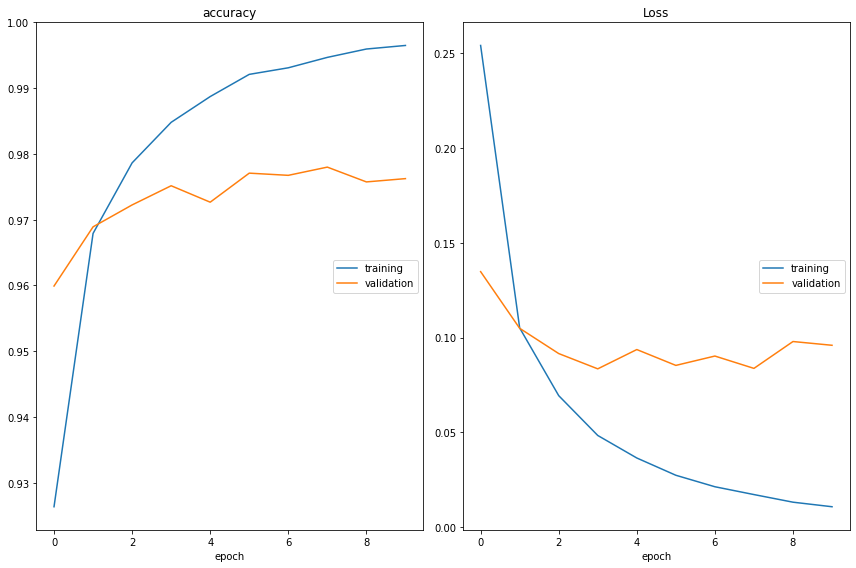

accuracy
	training         	 (min:    0.926, max:    0.997, cur:    0.997)
	validation       	 (min:    0.960, max:    0.978, cur:    0.976)
Loss
	training         	 (min:    0.011, max:    0.254, cur:    0.011)
	validation       	 (min:    0.083, max:    0.135, cur:    0.096)
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0959 - val_accuracy: 0.9762


In [41]:
# Train the model using training images and labels for 10 epochs with 20% of the data used for validation and plot the loss function
digits_model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

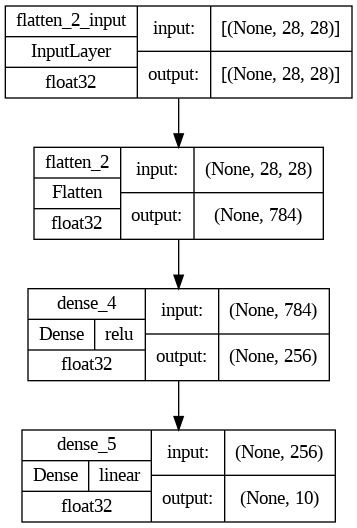

In [42]:
plot_model(
    digits_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

### Evaluate accuracy

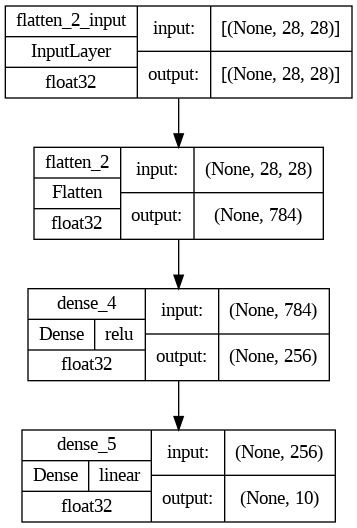

In [43]:
plot_model(
    digits_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

# Question 9

Now add a second Dense layer with 64 nodes, and print training and test accuracy.

## Build the model

In [44]:
digits_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

digits_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

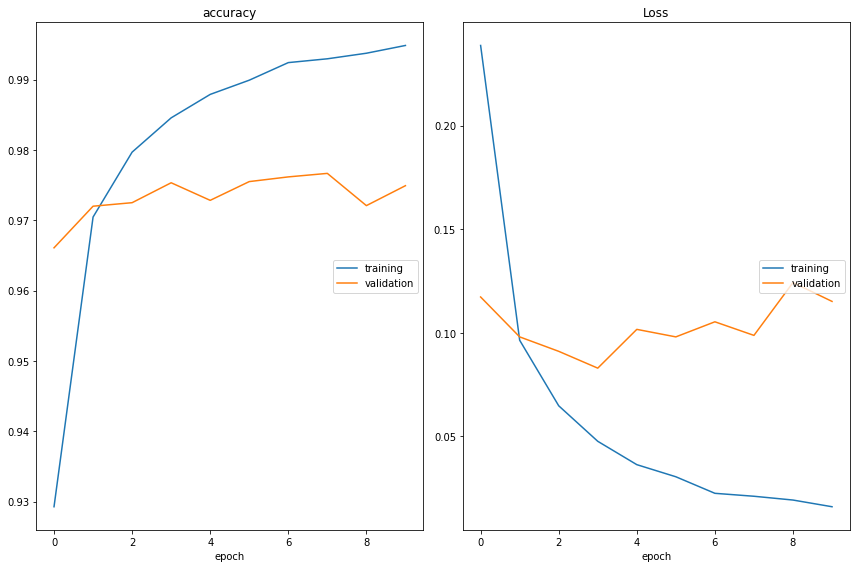

accuracy
	training         	 (min:    0.929, max:    0.995, cur:    0.995)
	validation       	 (min:    0.966, max:    0.977, cur:    0.975)
Loss
	training         	 (min:    0.016, max:    0.239, cur:    0.016)
	validation       	 (min:    0.083, max:    0.124, cur:    0.115)
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.1152 - val_accuracy: 0.9749


In [45]:
digits_model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

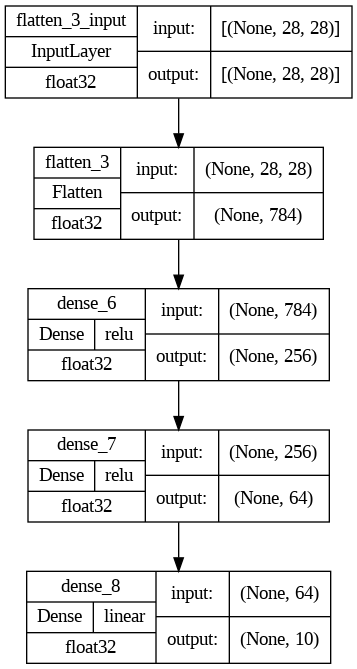

In [46]:
plot_model(
    digits_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

### Evaluate accuracy

In [47]:
train_loss, train_acc = digits_model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_acc = digits_model.evaluate(test_images,  test_labels, verbose=2)


print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

1875/1875 - 3s - loss: 0.0337 - accuracy: 0.9914 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.1001 - accuracy: 0.9766 - 1s/epoch - 4ms/step

Train accuracy: 0.9913666844367981
Test accuracy: 0.9765999913215637


# Question 10

Add a Dropout layer between the 256 node layer and the 64 node layer, with Dropout set to 0.2. Print train and test accuracy.

## Build the model

In [ ]:
digits_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

digits_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

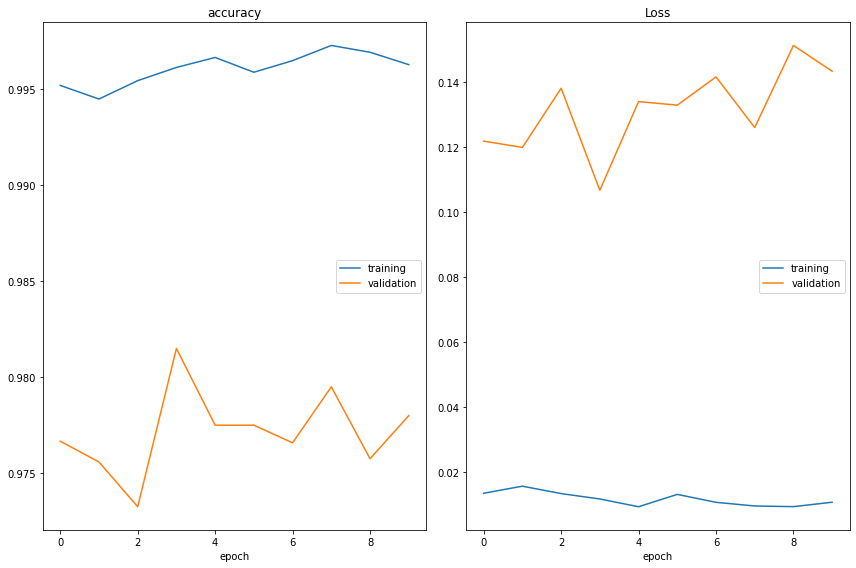

accuracy
	training         	 (min:    0.994, max:    0.997, cur:    0.996)
	validation       	 (min:    0.973, max:    0.982, cur:    0.978)
Loss
	training         	 (min:    0.009, max:    0.016, cur:    0.011)
	validation       	 (min:    0.107, max:    0.151, cur:    0.143)
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.1434 - val_accuracy: 0.9780


In [48]:
digits_model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

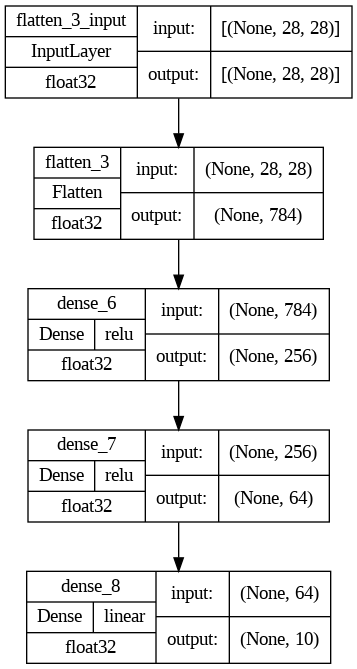

In [49]:
plot_model(
    digits_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

### Evaluate Accuracy

In [50]:
train_loss, train_acc = digits_model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_acc = digits_model.evaluate(test_images,  test_labels, verbose=2)


print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

1875/1875 - 3s - loss: 0.0334 - accuracy: 0.9942 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.1141 - accuracy: 0.9808 - 560ms/epoch - 2ms/step

Train accuracy: 0.9941999912261963
Test accuracy: 0.9807999730110168


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
